## LZV modeļa apmācība

Šī Jupyter grāmatiņa trenē LZV modeli, izmantojot pārneses mācīšanās stratēģiju no ASL modeļa, kas trenēts uz 42 orientieriem.

Lai palaistu šo grāmatiņu, ir nepieciešams:

* GitHub repo sagatavotais:
    * char_map.json
    * dataset_info.json
    * cslr_model_best_42.keras

* Jūsu pašu sagatavots:
    * training.tfrecord
    * validation.tfrecord

Galā tiks iegūts .keras training un prediction modelis, kā arī metadatu fails. 

---

### 1. Konfigurācija

Šobrīd ir noklusējuma opcijas. Spoguļattēla augmentācija mēdz pasliktināt, tādēļ USE_FLIP_AUGMENTATION = False.

In [2]:
import os
import json
import numpy as np
import sys
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import time
from datetime import datetime, timezone
from pathlib import Path
import jiwer
import math
import matplotlib.pyplot as plt


try:
    # Mapītes
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
    DATA_DIR = "..\data\processed_landmarks"

    TFRECORD_FILE = os.path.join(DATA_DIR, "training.tfrecord")
    TFRECORD_FILE_VAL = os.path.join(DATA_DIR, "validation.tfrecord")
    DATASET_INFO_FILE = os.path.join(DATA_DIR, "dataset_info.json")

    CHAR_MAP_FILE = os.path.join(DATA_DIR, "char_map.json")

    MODELS_BASE_DIR = os.path.join(BASE_DIR, "models")
    ASL_MODEL_PATH = os.path.join(MODELS_BASE_DIR, "asl\\42\\cslr_model_best_42.keras")
    OUTPUT_DIR = os.path.join(MODELS_BASE_DIR, "lzv")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Parametri
    EPOCHS = 300
    BATCH_SIZE = 4
    LEARNING_RATE = 1e-6
    FINE_TUNE_AT  = 20

    EPOCHS_PHASE_1 = 50
    EPOCHS_PHASE_2 = 200
    EPOCHS_PHASE_3 = 100

    LR_PHASE_1 = 1e-3
    LR_PHASE_2 = 5e-5
    LR_PHASE_3 = 1e-6

    NUM_LSTM_UNITS = 64
    NUM_CONV_FILTERS = 128
    CONV_KERNEL_SIZE = 5
    CONV_STRIDES = 1
    shuffle_buffer = 1000

    ASL_NUM_CLASSES_WITH_BLANK = 60
    NUM_CLASSES_WITH_BLANK = 46

    USE_AUGMENTATION = True
    USE_FLIP_AUGMENTATION = False # Spoguļattēla augmentācija

    # Simbolu vārdnīca
    with open(CHAR_MAP_FILE, 'r', encoding='utf-8') as f:
        char_map = json.load(f)
        id_to_char = {int(v): k for k, v in char_map.items()}

    inverse_char_map = {}
    try:
        inverse_char_map = {v: k for k, v in char_map.items()}
    except Exception as e:
        print(f"Error: {e}")


    # Metadatu fails
    with open(DATASET_INFO_FILE, 'r') as f:
        dataset_info = json.load(f)

    # Vērtību iegūšana no metadatu faila
    NUM_TRAIN_SAMPLES_LZV = dataset_info["dataset_stats"]["train_samples"]
    NUM_VAL_SAMPLES_LZV = dataset_info["dataset_stats"]["val_samples"]
    NUM_CLASSES_WITH_BLANK = dataset_info["num_classes_with_blank"]
    NUM_CLASSES = dataset_info["num_classes"]
    VOCAB_SIZE = NUM_CLASSES

    NUM_TRAIN_SAMPLES_AFTER_FILTER = NUM_TRAIN_SAMPLES_LZV
    NUM_VAL_SAMPLES_AFTER_FILTER = NUM_VAL_SAMPLES_LZV

    print(f"Number of training samples: {NUM_TRAIN_SAMPLES_LZV}")
    print(f"Number of validation samples: {NUM_VAL_SAMPLES_LZV}")
    print(f"Number of classes: {NUM_CLASSES}")
    print(f"Number of classes with blank: {NUM_CLASSES_WITH_BLANK}")

except Exception as e:
    print(f"Error: {e}")
    sys.exit(1)

Number of training samples: 254
Number of validation samples: 64
Number of classes: 45
Number of classes with blank: 46


### 2. Orientieri

Šie indeksi atbilst 543 punktu orientieriem, kas ir pieejami MediaPipe modeļos.

Šajā grāmatiņā tiek izmantots 42 roku orientieri, tomēr orientieru iedalījums 75 orientieru konfigurācijai un ķermeņa daļām arī ir atstāts.

Orientieru globālā indeksācija ir šāda:
* 33 pozas (0-32)
* 468 sejas (33-500)
* 21 kreisās rokas (501-521)
* 21 labās rokas (522-542)

In [ ]:
ORIGINAL_NUM_LANDMARKS = 543
LANDMARK_DIMS = 3

ALL_IDXS = list(range(1, 544))

POSE_SYMMETRY = [
    (11, 12), # Pleci
    (13, 14), # Elkoņi
    (15, 16), # Plecu locītavas
    (23, 24), # Gurni
]

FACE_SYMMETRY = [
    (33, 263),   # Ārējie acu stūri
    (133, 362),  # Iekšējie acu stūri
]

LIP_IDXS = [
    61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291,
    78, 191, 80, 81, 82, 312, 311, 310, 415, 308
]

LPOSE_IDXS_REL = [p[0] for p in POSE_SYMMETRY]
RPOSE_IDXS_REL = [p[1] for p in POSE_SYMMETRY]
LFACE_IDXS_REL = [p[0] for p in FACE_SYMMETRY]
RFACE_IDXS_REL = [p[1] for p in FACE_SYMMETRY]

LHAND_IDXS_ALL = list(range(501, 522))
RHAND_IDXS_ALL = list(range(522, 543))

training_indices_list = sorted(list(set(
    LHAND_IDXS_ALL + RHAND_IDXS_ALL
)))

TRAINING_IDXS = tf.constant(training_indices_list, dtype=tf.int32)
NEW_NUM_LANDMARKS = len(training_indices_list)
NUM_LANDMARKS = NEW_NUM_LANDMARKS

trim_idxs = tf.constant(training_indices_list, dtype=tf.int32)
TRIMMED_NUM_LANDMARKS = len(training_indices_list)
ASL_USED_LANDMARKS_COUNT = TRIMMED_NUM_LANDMARKS

print(f"Training landmark count: {TRIMMED_NUM_LANDMARKS}")
print(f"Training landmark indices: {training_indices_list}")

Training landmark count: 42
Training landmark indices: [501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542]


### 3. Dažādas palīgfunkcijas un augmentācijas funkcijas

In [4]:
feature_description = {
    "landmarks": tf.io.FixedLenFeature([], tf.string),
    "phrase": tf.io.VarLenFeature(tf.int64),
    "length": tf.io.FixedLenFeature([1], tf.int64),
    "phrase_length": tf.io.FixedLenFeature([1], tf.int64)
}

def interp1d_(tensor, new_size, axis=0):
    tensor_float = tf.cast(tensor, tf.float32)
    if tf.rank(tensor_float) != 3:
        raise ValueError("Input tensor must have rank 3 (time, landmarks, coords)")

    original_size = tf.shape(tensor_float)[axis]

    if axis == 0: # Interpolate along time
        reshaped = tf.reshape(tensor_float, [original_size, -1, 1])
        resized = tf.image.resize(reshaped, [new_size, tf.shape(reshaped)[1]], method='bilinear')
        output = tf.reshape(resized, [new_size, tf.shape(tensor_float)[1], tf.shape(tensor_float)[2]])
    else:
        raise ValueError("Interpolation along axis != 0 not implemented here")

    return output

def find_next_experiment_index(base_models_dir):
    index = 1
    while True:
        experiment_dir = os.path.join(base_models_dir, str(index))
        if not os.path.isdir(experiment_dir):
            return index
        index += 1

def format_time(seconds):
    if seconds is None: return None
    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

def inspect_tensor(tensor, message="Tensor"):
    is_finite = tf.math.is_finite(tensor)
    all_finite = tf.reduce_all(is_finite)
    finite_values = tf.boolean_mask(tensor, is_finite)
    has_finite_values = tf.size(finite_values) > 0

    min_val = tf.cond(has_finite_values, lambda: tf.reduce_min(finite_values), lambda: tf.constant(0.0, dtype=tensor.dtype))
    max_val = tf.cond(has_finite_values, lambda: tf.reduce_max(finite_values), lambda: tf.constant(0.0, dtype=tensor.dtype))
    mean_val = tf.cond(has_finite_values, lambda: tf.reduce_mean(tf.cast(finite_values, tf.float32)), lambda: tf.constant(0.0, dtype=tf.float32))

    tf.print(f"DEBUG {message}: Shape={tf.shape(tensor)}, Min={min_val}, Max={max_val}, Mean={mean_val}, AllFinite={all_finite}",
        output_stream=sys.stderr)
    return tensor


LPOSE_IDXS = tf.constant([p[0] for p in POSE_SYMMETRY], dtype=tf.int32)
RPOSE_IDXS = tf.constant([p[1] for p in POSE_SYMMETRY], dtype=tf.int32)
LFACE_IDXS = tf.constant([p[0] for p in FACE_SYMMETRY], dtype=tf.int32)
RFACE_IDXS = tf.constant([p[1] for p in FACE_SYMMETRY], dtype=tf.int32)
LHAND_IDXS = tf.constant(LHAND_IDXS_ALL, dtype=tf.int32)
RHAND_IDXS = tf.constant(RHAND_IDXS_ALL, dtype=tf.int32)

LPOSE_SCATTER_IDX = LPOSE_IDXS[:, None]
RPOSE_SCATTER_IDX = RPOSE_IDXS[:, None]
LFACE_SCATTER_IDX = LFACE_IDXS[:, None]
RFACE_SCATTER_IDX = RFACE_IDXS[:, None]
LHAND_SCATTER_IDX = LHAND_IDXS[:, None]
RHAND_SCATTER_IDX = RHAND_IDXS[:, None]

@tf.function
# Spoguļattēla augmentācija
def flip_lr_adapted(x):
    x_flipped = tf.stack([-x[..., 0], x[..., 1], x[..., 2]], axis=-1)

    def swap_landmarks_for_frame(frame_flipped):
        left_hand_vals = tf.gather(frame_flipped, LHAND_IDXS, axis=0)
        right_hand_vals = tf.gather(frame_flipped, RHAND_IDXS, axis=0)
        left_pose_vals = tf.gather(frame_flipped, LPOSE_IDXS, axis=0)
        right_pose_vals = tf.gather(frame_flipped, RPOSE_IDXS, axis=0)
        left_face_vals = tf.gather(frame_flipped, LFACE_IDXS, axis=0)
        right_face_vals = tf.gather(frame_flipped, RFACE_IDXS, axis=0)

        frame_swapped = frame_flipped
        frame_swapped = tf.tensor_scatter_nd_update(frame_swapped, LHAND_SCATTER_IDX, right_hand_vals)
        frame_swapped = tf.tensor_scatter_nd_update(frame_swapped, RHAND_SCATTER_IDX, left_hand_vals)
        frame_swapped = tf.tensor_scatter_nd_update(frame_swapped, LPOSE_SCATTER_IDX, right_pose_vals)
        frame_swapped = tf.tensor_scatter_nd_update(frame_swapped, RPOSE_SCATTER_IDX, left_pose_vals)
        frame_swapped = tf.tensor_scatter_nd_update(frame_swapped, LFACE_SCATTER_IDX, right_face_vals)
        frame_swapped = tf.tensor_scatter_nd_update(frame_swapped, RFACE_SCATTER_IDX, left_face_vals)
        return frame_swapped

    x_swapped_time_series = tf.map_fn(
        swap_landmarks_for_frame,
        tf.cast(x_flipped, tf.float32),
        fn_output_signature=tf.float32
    )
    original_shape = tf.shape(x)
    x_swapped_time_series = tf.reshape(x_swapped_time_series, original_shape)
    return x_swapped_time_series

# Telpiskās augmentācijas
def spatial_random_affine_adapted(xyz,
                                scale=(0.8, 1.2),
                                shear=(-0.15, 0.15),
                                shift=(-0.1, 0.1),
                                degree=(-15, 15),
                               ):
    center = tf.constant([0.0, 0.0])
    xyz_transformed = xyz

    if scale is not None:
        scale_factor = tf.random.uniform((), *scale)
        xyz_transformed = scale_factor * xyz_transformed

    if shear is not None:
        xy = xyz_transformed[..., :2]
        z = xyz_transformed[..., 2:]
        shear_x = shear_y = tf.random.uniform((), *shear)
        if tf.random.uniform(()) < 0.5: shear_x = 0.
        else: shear_y = 0.
        shear_mat = tf.convert_to_tensor([[1., shear_x], [shear_y, 1.]], dtype=tf.float32)
        xy_sheared = tf.einsum('...ij,...j->...i', shear_mat, xy)
        xyz_transformed = tf.concat([xy_sheared, z], axis=-1)

    if degree is not None:
        xy = xyz_transformed[..., :2]
        z = xyz_transformed[..., 2:]
        degree_val = tf.random.uniform((), *degree)
        radian = degree_val / 180.0 * np.pi
        c = tf.cos(radian)
        s = tf.sin(radian)
        rotate_mat = tf.convert_to_tensor([[c, s], [-s, c]], dtype=tf.float32)
        xy_rotated = tf.einsum('...ij,...j->...i', rotate_mat, xy)
        xyz_transformed = tf.concat([xy_rotated, z], axis=-1)

    if shift is not None:
        shift_val_x = tf.random.uniform((), *shift)
        shift_val_y = tf.random.uniform((), *shift)
        shift_val_z = tf.constant(0.0, dtype=tf.float32)
        shift_vector = tf.stack([shift_val_x, shift_val_y, shift_val_z], axis=0)
        xyz_transformed += shift_vector

    return xyz_transformed

# Laika ass augmentācija
def resample_adapted(x, rate=(0.8, 1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate * tf.cast(length, tf.float32), tf.int32)
    new_size = tf.maximum(new_size, 1)
    new_x = interp1d_(x, new_size, axis=0)
    return new_x

# Maskēšanas augmentācija
def temporal_mask_adapted(x, size=(0.2, 0.4), mask_value=0.0):
    l = tf.shape(x)[0]
    if l <= 1:
        return x

    mask_size_ratio = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size_ratio, tf.int32)
    mask_size = tf.clip_by_value(mask_size, 0, l)

    if mask_size == 0:
        return x

    max_offset = l - mask_size
    mask_offset = tf.random.uniform((), 0, max_offset + 1, dtype=tf.int32)

    indices_to_update = tf.range(mask_offset, mask_offset + mask_size)
    updates = tf.fill([mask_size, tf.shape(x)[1], tf.shape(x)[2]], tf.cast(mask_value, x.dtype))

    x = tf.tensor_scatter_nd_update(x, indices_to_update[..., None], updates)
    return x

# Piemēro notikšanas varbūtību augmentāciju funkcijām
def augment_fn_adapted(x, use_resample=True):
    original_length = tf.shape(x)[0]
    if use_resample:
        if tf.random.uniform(()) < 0.9:
            x = resample_adapted(x, (0.7, 1.3))

    if tf.random.uniform(()) < 0.5:
        x = temporal_mask_adapted(x, size=(0.1, 0.3))

    if tf.random.uniform(()) < 0.75:
        x = spatial_random_affine_adapted(x)

    if USE_FLIP_AUGMENTATION:
        if tf.random.uniform(()) < 0.5:
            x = flip_lr_adapted(x)

    return x

# Parsē TFRecord failu
def parse_tfrecord_fn_for_filter(example):
    features = tf.io.parse_single_example(example, feature_description)
    landmarks = tf.io.decode_raw(features['landmarks'], tf.float32)
    seq_len = features['length'][0]
    phrase_len = features['phrase_length'][0]

    landmarks = tf.reshape(landmarks, (seq_len, ORIGINAL_NUM_LANDMARKS, LANDMARK_DIMS))
    phrase = tf.sparse.to_dense(features['phrase'])

    return landmarks, phrase, seq_len, phrase_len

# Filtrēšanas funkcija, lai atlasītu tikai piemērus ar pietiekamu garumu
@tf.function
def filter_ctc_length(landmarks, phrase, landmark_length, phrase_length):
    phrase_length = phrase_length + CONV_KERNEL_SIZE
    return tf.greater_equal(landmark_length, phrase_length)

### 4. Normalizācija

Normalizācijas dati (standartnovirzes un vidējās vērtības) tiek izrēķināti uz vietas šajā grāmatiņā.

In [5]:
combined_mean = None
combined_std = None
num_lzv_train_samples_for_stats = 0

try:
    stats_raw_dataset_lzv = tf.data.TFRecordDataset([TFRECORD_FILE])
    stats_parsed_dataset_lzv = stats_raw_dataset_lzv.map(
        parse_tfrecord_fn_for_filter, num_parallel_calls=tf.data.AUTOTUNE
    )
    stats_filtered_dataset_lzv = stats_parsed_dataset_lzv.filter(filter_ctc_length)

    print("Iterating for mean/std started...")
    total_frames_lzv = 0
    landmark_sum_lzv = np.zeros((ORIGINAL_NUM_LANDMARKS, LANDMARK_DIMS), dtype=np.float64)
    landmark_sum_sq_lzv = np.zeros((ORIGINAL_NUM_LANDMARKS, LANDMARK_DIMS), dtype=np.float64)

    for landmarks_raw, _, landmark_length, _ in tqdm(stats_filtered_dataset_lzv, desc="Calculating LZV Stats"):
        current_frames = tf.shape(landmarks_raw)[0].numpy()
        if current_frames > 0:
            total_frames_lzv += current_frames
            landmark_sum_lzv += np.sum(landmarks_raw.numpy().astype(np.float64), axis=0)
            landmark_sum_sq_lzv += np.sum(np.square(landmarks_raw.numpy().astype(np.float64)), axis=0)
            num_lzv_train_samples_for_stats += 1
    
    if total_frames_lzv == 0:
        raise ValueError("No valid frames found in the filtered dataset to calculate statistics.")

    print(f"Processed {num_lzv_train_samples_for_stats} LZV samples with {total_frames_lzv} total frames.")

    mean_np_lzv = (landmark_sum_lzv / total_frames_lzv).astype(np.float32)
    variance_np_lzv = (landmark_sum_sq_lzv / total_frames_lzv) - np.square(mean_np_lzv)
    variance_np_lzv = np.maximum(variance_np_lzv, 0) 
    std_np_lzv = np.sqrt(variance_np_lzv).astype(np.float32)

    combined_mean = tf.constant(mean_np_lzv, dtype=tf.float32)[tf.newaxis, :, :]
    combined_std = tf.constant(std_np_lzv, dtype=tf.float32)[tf.newaxis, :, :]

    epsilon = 1e-6
    combined_std = tf.where(combined_std < epsilon, epsilon, combined_std)

    print(f"\nLZV Combined mean shape for broadcasting: {combined_mean.shape}")
    print(f"LZV Combined std shape for broadcasting: {combined_std.shape}")
    print("On-the-spot LZV normalization stats calculated and prepared.")

except Exception as e:
    print(f"Error: {e}")
    sys.exit(1)

Iterating for mean/std started...


Calculating LZV Stats: 253it [00:00, 282.28it/s]

Processed 253 LZV samples with 44934 total frames.

LZV Combined mean shape for broadcasting: (1, 543, 3)
LZV Combined std shape for broadcasting: (1, 543, 3)
On-the-spot LZV normalization stats calculated and prepared.


### 5. ASL modeļa rekonstrukcija

ASL modelis ir trenēts uz daudz vairāk datiem, nekā LZV. ASL modeļa struktūra ir tieši tāda pati, kādu izmanto LZV modelim.

Lai varētu izmantot pārneses mācīšanās stratēģiju, ASL modeli ir nepieciešams rekonstruēt.

In [6]:
from keras.config import enable_unsafe_deserialization
enable_unsafe_deserialization()

def build_asl_model_architecture_corrected(asl_num_landmarks, asl_landmark_dims, num_classes_asl, asl_num_lstm_units, asl_num_conv_filters, asl_conv_kernel_size, asl_conv_strides):
    print(f"\n ASL architecture: input shape (None, None, {asl_num_landmarks}, {asl_landmark_dims}) and {num_classes_asl} ASL classes")
    
    input_landmarks = keras.Input(shape=(None, asl_num_landmarks, asl_landmark_dims), dtype=tf.float32, name='input_landmarks')
    input_labels = keras.Input(shape=(None,), dtype=tf.int64, name='input_labels')
    input_landmark_length = keras.Input(shape=(1,), dtype=tf.int64, name='input_landmark_length')
    input_label_length = keras.Input(shape=(1,), dtype=tf.int64, name='input_label_length')

    x = layers.Reshape((-1, asl_num_landmarks * asl_landmark_dims), name='reshape_input')(input_landmarks)
    
    x = layers.Conv1D(filters=asl_num_conv_filters, kernel_size=asl_conv_kernel_size, strides=asl_conv_strides,
                      padding='same', activation='relu', name='conv1d_layer')(x)
    x = layers.BatchNormalization(name='batchnorm_conv')(x)
    
    x = layers.Bidirectional(layers.LSTM(asl_num_lstm_units, return_sequences=True), name='bilstm_1')(x)

    bilstm_output = x
    x = layers.BatchNormalization(name='batchnorm_lstm1')(x)
    batchnorm_lstm1_output = x

    output_logits = layers.TimeDistributed(layers.Dense(num_classes_asl, activation='softmax'), name='output_dense_softmax')(batchnorm_lstm1_output)
    
    squeezed_landmark_length = layers.Lambda(lambda t: tf.squeeze(t, axis=-1), name='squeeze_lm_len')(input_landmark_length)
    squeezed_label_length = layers.Lambda(lambda t: tf.squeeze(t, axis=-1), name='squeeze_ph_len')(input_label_length)
    
    loss_output = tf.keras.layers.Lambda(
        lambda args_in: tf.keras.backend.ctc_batch_cost(
            y_true=args_in[0], y_pred=args_in[1],
            input_length=tf.expand_dims(args_in[2], axis=-1), label_length=tf.expand_dims(args_in[3], axis=-1)
        ), name='ctc_loss'
    )([input_labels, output_logits, squeezed_landmark_length, squeezed_label_length])
    
    reconstructed_asl_training_model = keras.Model(
        inputs={'input_landmarks': input_landmarks, 'input_labels': input_labels,
                'input_landmark_length': input_landmark_length, 'input_label_length': input_label_length},
        outputs=loss_output, name='cslr_training_model'
    )
    
    print("Corrected ASL architecture (training structure) reconstructed.")
    return reconstructed_asl_training_model


asl_training_model_base_loaded = None

try:
    print(f"Reconstructing ASL model with corrected architecture to load weights from: {ASL_MODEL_PATH}")
    
    reconstructed_asl_model_shell = build_asl_model_architecture_corrected(
        asl_num_landmarks=ASL_USED_LANDMARKS_COUNT,
        asl_landmark_dims=LANDMARK_DIMS,
        num_classes_asl=ASL_NUM_CLASSES_WITH_BLANK,
        asl_num_lstm_units=NUM_LSTM_UNITS,
        asl_num_conv_filters=NUM_CONV_FILTERS,
        asl_conv_kernel_size=CONV_KERNEL_SIZE,
        asl_conv_strides=CONV_STRIDES
    )

    print(f"Loading weights from {ASL_MODEL_PATH} into corrected ASL training model shell...")
    reconstructed_asl_model_shell.load_weights(ASL_MODEL_PATH)
    print("Weights loaded successfully into the corrected ASL model shell.")

    print("Defining the base for fine-tuning (feature extractor part of the ASL model)...")

    if 'input_landmarks' in reconstructed_asl_model_shell.input:
        feature_base_input = reconstructed_asl_model_shell.input['input_landmarks']
        print(f"Fetched 'input_landmarks' from model.input dict: {feature_base_input}")
    else:
        raise ValueError("'input_landmarks' not found as a key in reconstructed_asl_model_shell.input dictionary.")

    if feature_base_input is None or (isinstance(feature_base_input, list) and not feature_base_input):
        raise ValueError(f"feature_base_input is None or empty. Value: {feature_base_input}")

    feature_base_output = reconstructed_asl_model_shell.get_layer('batchnorm_lstm1').output

    asl_training_model_base_loaded = keras.Model(
        inputs=feature_base_input,
        outputs=feature_base_output,
        name="asl_loaded_feature_base"
    )
    asl_training_model_base_loaded.summary()
    print("Base model for fine-tuning created.")

except Exception as e:
    print(f"Error: {e}")
    raise SystemExit(1)
    

def build_cslr_fine_tune_model(feature_extractor_base, num_lzv_classes_with_blank):
    print(f"\nBuilding fine-tune model with {num_lzv_classes_with_blank} LZV classes (incl. blank) using the provided feature_extractor_base")
    
    feature_extractor_base.trainable = False 
    print(f"Feature extractor base '{feature_extractor_base.name}' has been INITIALLY set to trainable=False.")

    input_landmarks_lzv = feature_extractor_base.input
    input_labels_lzv = keras.Input(shape=(None,), dtype=tf.int64, name='input_labels_lzv')
    input_landmark_length_lzv = keras.Input(shape=(1,), dtype=tf.int64, name='input_landmark_length_lzv')
    input_label_length_lzv = keras.Input(shape=(1,), dtype=tf.int64, name='input_label_length_lzv')

    base_output = feature_extractor_base.output
    output_logits_lzv = layers.TimeDistributed(
        layers.Dense(num_lzv_classes_with_blank, activation='softmax'), name='output_dense_softmax_lzv'
    )(base_output)
    
    squeezed_landmark_length_lzv = layers.Lambda(lambda t: tf.squeeze(t, axis=-1), name='squeeze_lm_len_lzv')(input_landmark_length_lzv)
    squeezed_label_length_lzv = layers.Lambda(lambda t: tf.squeeze(t, axis=-1), name='squeeze_ph_len_lzv')(input_label_length_lzv)

    loss_output_lzv = tf.keras.layers.Lambda(
        lambda args: tf.keras.backend.ctc_batch_cost(
            y_true=args[0], y_pred=args[1],
            input_length=tf.expand_dims(args[2], axis=-1), label_length=tf.expand_dims(args[3], axis=-1)
        ), name='ctc_loss_lzv'
    )([input_labels_lzv, output_logits_lzv, squeezed_landmark_length_lzv, squeezed_label_length_lzv])

    fine_tune_training_model = keras.Model(
        inputs={'input_landmarks': input_landmarks_lzv, 'input_labels': input_labels_lzv,
                'input_landmark_length': input_landmark_length_lzv, 'input_label_length': input_label_length_lzv},
        outputs=loss_output_lzv, name='cslr_lzv_fine_tune_training_model'
    )
    lzv_prediction_model = keras.Model(inputs=input_landmarks_lzv, outputs=output_logits_lzv, name='cslr_lzv_prediction_model')
    print("\nLZV Fine-tuning and Prediction models built.")
    return fine_tune_training_model, lzv_prediction_model


if asl_training_model_base_loaded is not None:
    training_model, prediction_model = build_cslr_fine_tune_model(
        feature_extractor_base=asl_training_model_base_loaded,
        num_lzv_classes_with_blank=NUM_CLASSES_WITH_BLANK
    )
    print("\n--- Final LZV Fine-tuning Model Summary ---")
    training_model.summary(line_length=120)
    print("\n--- Final LZV Prediction Model Summary ---")
    prediction_model.summary(line_length=100)
else:
    print("Error: ASL model was not reconstrued properly.")
    sys.exit(1)

Reconstructing ASL model with corrected architecture to load weights from: c:\Users\liene\Documents\GitHub\LZV-CSLR\models\asl\42\cslr_model_best_42.keras

 ASL architecture: input shape (None, None, 42, 3) and 60 ASL classes


Corrected ASL architecture (training structure) reconstructed.
Loading weights from c:\Users\liene\Documents\GitHub\LZV-CSLR\models\asl\42\cslr_model_best_42.keras into corrected ASL training model shell...
Weights loaded successfully into the corrected ASL model shell.
Defining the base for fine-tuning (feature extractor part of the ASL model)...
Fetched 'input_landmarks' from model.input dict: <KerasTensor shape=(None, None, 42, 3), dtype=float32, sparse=False, name=input_landmarks>


Model: "asl_loaded_feature_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_landmarks (InputLayer)    │ (None, None, 42, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_input (Reshape)         │ (None, None, 126)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_layer (Conv1D)           │ (None, None, 128)      │        80,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_conv                  │ (None, None, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, None, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_lstm1                 │ (None, None, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,608 (705.50 KB)

 Trainable params: 180,096 (703.50 KB)

 Non-trainable params: 512 (2.00 KB)

Base model for fine-tuning created.

Building fine-tune model with 46 LZV classes (incl. blank) using the provided feature_extractor_base
Feature extractor base 'asl_loaded_feature_base' has been INITIALLY set to trainable=False.

LZV Fine-tuning and Prediction models built.

--- Final LZV Fine-tuning Model Summary ---


c:\Users\liene\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'input_labels' mapping to value <KerasTensor shape=(None, None), dtype=int64, sparse=False, name=input_labels_lzv> which has name 'input_labels_lzv'. Change the tensor name to 'input_labels' (via `Input(..., name='input_labels')`)
  warnings.warn(
c:\Users\liene\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'input_landmark_length' mapping to value <KerasTensor shape=(None, 1), dtype=int64, sparse=False, name=input_landmark_length_lzv> which has name 'input_landmark_length_lzv'. Change the tensor name to 'input_landmark_length' (via `Input(..., name='input_landmark_length

Model: "cslr_lzv_fine_tune_training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_landmarks (InputLayer)      │ (None, None, 42, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_input (Reshape)           │ (None, None, 126)            │                 0 │ input_landmarks[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1d_layer (Conv1D)             │ (None, None, 128)            │            80,768 │ reshape_input[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batchnorm_conv                    │ (None, None, 128)            │               512 │ conv1d_layer[0][0]        
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bilstm_1 (Bidirectional)          │ (None, None, 128)            │            98,816 │ batchnorm_conv[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batchnorm_lstm1                   │ (None, None, 128)            │               512 │ bilstm_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_landmark_length_lzv         │ (None, 1)                    │                 0 │ -                         
│ (InputLayer)                      │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_label_length_lzv            │ (None, 1)                    │                 0 │ -                         
│ (InputLayer)                      │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_labels_lzv (InputLayer)     │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ output_dense_softmax_lzv          │ (None, None, 46)             │             5,934 │ batchnorm_lstm1[0][0]     
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ squeeze_lm_len_lzv (Lambda)       │ (None)                       │                 0 │ input_landmark_length_lzv[
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ squeeze_ph_len_lzv (Lambda)       │ (None)                       │                 0 │ input_label_length_lzv[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ctc_loss_lzv (Lambda)             │ (None, 1)                    │                 0 │ input_labels_lzv[0][0],   
│                                   │                              │                   │ output_dense_softmax_lzv[0
│                                   │                   

 Total params: 186,542 (728.68 KB)

 Trainable params: 5,934 (23.18 KB)

 Non-trainable params: 180,608 (705.50 KB)


--- Final LZV Prediction Model Summary ---


Model: "cslr_lzv_prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_landmarks (InputLayer)               │ (None, None, 42, 3)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ reshape_input (Reshape)                    │ (None, None, 126)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv1d_layer (Conv1D)                      │ (None, None, 128)               │            80,768 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batchnorm_conv (BatchNormalization)        │ (None, None, 128)               │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bilstm_1 (Bidirectional)                   │ (None, None, 128)               │            98,816 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batchnorm_lstm1 (BatchNormalization)       │ (None, None, 128)               │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ output_dense_softmax_lzv (TimeDistributed) │ (None, None, 46)                │             5,934 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 186,542 (728.68 KB)

 Trainable params: 5,934 (23.18 KB)

 Non-trainable params: 180,608 (705.50 KB)

### 6. Modeļa slāņu atsaldēšana

Konfigurācija modeļa pakāpeniskai 3 fāžu slāņu atsaldēšanai.

In [7]:
UNFREEZE_BN_IN_BASE = True
UNFREEZE_LAST_BILSTM_IN_BASE = True
UNFREEZE_CONV1D_IN_BASE = False

if 'training_model' in locals() and training_model is not None:
    made_layer_trainable_changes = 0
    for layer in training_model.layers:
        if layer.name == 'conv1d_layer':
            if layer.trainable and not UNFREEZE_CONV1D_IN_BASE:
                layer.trainable = False
                made_layer_trainable_changes +=1
                print(f"  Froze layer: {layer.name}")
            elif not layer.trainable and UNFREEZE_CONV1D_IN_BASE:
                layer.trainable = True
                made_layer_trainable_changes +=1
                print(f"  Unfroze layer: {layer.name}")
        elif layer.name == 'bilstm_1':
            if not layer.trainable and UNFREEZE_LAST_BILSTM_IN_BASE:
                layer.trainable = True
                made_layer_trainable_changes +=1
                print(f"  Unfroze layer: {layer.name}")
            elif layer.trainable and not UNFREEZE_LAST_BILSTM_IN_BASE:
                layer.trainable = False
                made_layer_trainable_changes +=1
                print(f"  Froze layer: {layer.name}")
        elif layer.name in ['batchnorm_conv', 'batchnorm_lstm1']:
            if not layer.trainable and UNFREEZE_BN_IN_BASE:
                layer.trainable = True
                made_layer_trainable_changes +=1
                print(f"  Unfroze layer: {layer.name}")
            elif layer.trainable and not UNFREEZE_BN_IN_BASE:
                layer.trainable = False
                made_layer_trainable_changes +=1
                print(f"  Froze layer: {layer.name}")

    if made_layer_trainable_changes > 0:
        print(f"Trainable status of {made_layer_trainable_changes} base layers updated.")
    else:
        print("No changes needed.")

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0) 
    training_model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)

    print("\nSummary of 'training_model' AFTER adjusting layer trainability & recompiling:")
    training_model.summary(line_length=120) # Trenējamie parametriem vajadzētu būt: ~105,262
else:
    print("Error: 'training_model' not defined.")

  Unfroze layer: batchnorm_conv
  Unfroze layer: bilstm_1
  Unfroze layer: batchnorm_lstm1
Trainable status of 3 base layers updated.

Summary of 'training_model' AFTER adjusting layer trainability & recompiling:


Model: "cslr_lzv_fine_tune_training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_landmarks (InputLayer)      │ (None, None, 42, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_input (Reshape)           │ (None, None, 126)            │                 0 │ input_landmarks[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1d_layer (Conv1D)             │ (None, None, 128)            │            80,768 │ reshape_input[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batchnorm_conv                    │ (None, None, 128)            │               512 │ conv1d_layer[0][0]        
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bilstm_1 (Bidirectional)          │ (None, None, 128)            │            98,816 │ batchnorm_conv[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batchnorm_lstm1                   │ (None, None, 128)            │               512 │ bilstm_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_landmark_length_lzv         │ (None, 1)                    │                 0 │ -                         
│ (InputLayer)                      │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_label_length_lzv            │ (None, 1)                    │                 0 │ -                         
│ (InputLayer)                      │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_labels_lzv (InputLayer)     │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ output_dense_softmax_lzv          │ (None, None, 46)             │             5,934 │ batchnorm_lstm1[0][0]     
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ squeeze_lm_len_lzv (Lambda)       │ (None)                       │                 0 │ input_landmark_length_lzv[
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ squeeze_ph_len_lzv (Lambda)       │ (None)                       │                 0 │ input_label_length_lzv[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ctc_loss_lzv (Lambda)             │ (None, 1)                    │                 0 │ input_labels_lzv[0][0],   
│                                   │                              │                   │ output_dense_softmax_lzv[0
│                                   │                   

 Total params: 186,542 (728.68 KB)

 Trainable params: 105,262 (411.18 KB)

 Non-trainable params: 81,280 (317.50 KB)

### 7. WER metrika

Modeļu novērtēšanai tiek izmantota WER (word error rate) metrika, kas nepieciešama modeļa apmācībā, lai novērtētu precizitāti uz validācijas kopu.

Jo WER ir tuvāks 0, jo modelis spēj atpazīt zīmes labāk.

Pēc noklusējuma tiek izmantots alkatīgais algoritms (greedy).

In [ ]:
class WERCallback(Callback):
    # Inicializē WERCallback
    def __init__(self, prediction_model, validation_dataset, validation_steps,
                 inverse_char_map, epoch_frequency=1, use_beam_search=False, log_prefix='val_wer'):
        super().__init__()
        self.prediction_model = prediction_model
        self.validation_dataset = validation_dataset
        self.validation_steps = validation_steps
        self.inverse_char_map = inverse_char_map
        self.epoch_frequency = max(1, epoch_frequency)
        self.use_beam_search = use_beam_search
        self.log_prefix = log_prefix
        self.best_metric = float('inf')
        self.best_metric_epoch = 0
        print(f"\nWERCallback initialized:")
        print(f"  Decoder: {'Beam Search' if self.use_beam_search else 'Greedy'}")
        print(f"  Metric Log Name: {self.log_prefix}")

    # Dekodē prognozes no modeļa un atgriež indeksu secību
    def decode_batch_predictions(self, y_pred_softmax):
        y_pred_time_major = tf.transpose(y_pred_softmax, perm=[1, 0, 2])
        pred_seq_len = tf.cast(tf.fill(tf.shape(y_pred_softmax)[:1], tf.shape(y_pred_softmax)[1]), dtype=tf.int32)

        if self.use_beam_search:
            decoded_sparse_list, _ = tf.nn.ctc_beam_search_decoder(
                y_pred_time_major, sequence_length=pred_seq_len, beam_width=10, top_paths=1)
            decoded_sparse = decoded_sparse_list[0]
        else:
            decoded_list, _ = tf.nn.ctc_greedy_decoder(
                y_pred_time_major, sequence_length=pred_seq_len)
            decoded_sparse = decoded_list[0]

        dense_decoded = tf.sparse.to_dense(decoded_sparse, default_value=-1).numpy()
        return dense_decoded

    # Izmanto vārdnīcu, lai indeksus pārvērstu uz zīmēm
    def map_indices_to_signs(self, index_sequence):
        filtered_sequence = [int(idx) for idx in index_sequence if idx != -1]
        return " ".join([self.inverse_char_map.get(idx, '?') for idx in filtered_sequence])

    # Notiek pēc katras epohas beigām
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if (epoch + 1) % self.epoch_frequency == 0:
            print(f"\nEpoch {epoch + 1}: Calculating Validation WER/CER...")
            all_true_phrases_str = []
            all_pred_phrases_str = []
            successfully_processed_pairs = 0

            if self.validation_dataset is None:
                print("  Error: Validation dataset not provided. Skipping WER.")
                current_metric = float('inf')
            else:
                iterator = iter(self.validation_dataset)
                steps_done = 0
                try:
                    while self.validation_steps is None or steps_done < self.validation_steps:
                        batch_landmarks, batch_phrase, batch_landmark_len, batch_phrase_len = next(iterator)
                        
                        y_pred_softmax = None
                        decoded_indices_batch = None
                        try:
                            y_pred_softmax = self.prediction_model.predict(batch_landmarks, verbose=0)
                            decoded_indices_batch = self.decode_batch_predictions(y_pred_softmax)
                        except Exception as e_batch_pred_decode:
                            print(f"  Error during batch-level prediction/decoding in batch {steps_done}: {e_batch_pred_decode}")
                            pass

                        for j in range(tf.shape(batch_landmarks)[0].numpy()):
                            sample_processed_successfully = False
                            try:
                                true_idxs_padded = batch_phrase[j]
                                true_len_scalar = batch_phrase_len[j].numpy()
                                if isinstance(true_len_scalar, np.ndarray) and true_len_scalar.ndim > 0:
                                    true_len_scalar = true_len_scalar[0]
                                true_idxs = true_idxs_padded[:true_len_scalar].numpy()
                                true_str = self.map_indices_to_signs(true_idxs)
                                if not true_str: true_str = "<empty_true>"

                                if decoded_indices_batch is not None and j < len(decoded_indices_batch):
                                    pred_idxs = decoded_indices_batch[j]
                                    pred_str = self.map_indices_to_signs(pred_idxs)
                                    if not pred_str: pred_str = "<empty_pred>"
                                else:
                                    pred_str = "<pred_decode_error>"
                                    print(f"  WARNING: Issue with decoded_indices_batch for sample {j} in batch {steps_done}.")


                                all_true_phrases_str.append(true_str)
                                all_pred_phrases_str.append(pred_str)
                                successfully_processed_pairs += 1
                                sample_processed_successfully = True

                                if steps_done == 0 and j == 0 and sample_processed_successfully:
                                    print(f"  Example True: '{true_str}'")
                                    print(f"  Example Pred: '{pred_str}'")

                            except Exception as e_sample:
                                print(f"  ERROR processing sample {j} in batch {steps_done}: {e_sample}")
                                all_true_phrases_str.append(f"<error_true_s{j}_b{steps_done}>")
                                all_pred_phrases_str.append(f"<error_pred_s{j}_b{steps_done}>")
                                successfully_processed_pairs +=1

                        steps_done += 1
                
                except tf.errors.OutOfRangeError:
                    if self.validation_steps is None: print("  Reached end of validation dataset.")
                except StopIteration:
                    print("  Validation iterator exhausted.")
                except Exception as e_outer:
                    print(f"  Error during validation data iteration: {e_outer}")

                if not all_true_phrases_str or not all_pred_phrases_str or len(all_true_phrases_str) != len(all_pred_phrases_str):
                    print("  CRITICAL ERROR JIWER: Mismatch in lengths or empty lists for true/pred phrases. Skipping WER calculation for this epoch.")
                    current_metric = float('inf')
                else:
                    try:
                        current_metric = jiwer.wer(all_true_phrases_str, all_pred_phrases_str)
                        print(f"  Successfully calculated WER: {current_metric:.4f} using {len(all_true_phrases_str)} pairs.")
                    except Exception as e_jiwer:
                        print(f"  ERROR during jiwer.wer calculation: {e_jiwer}")
                        current_metric = float('inf')
            
            logs[self.log_prefix] = current_metric

            # Labākās metrikas izvade
            if current_metric < self.best_metric:
                print(f"  New best validation WER: {current_metric:.4f} (previous: {self.best_metric:.4f} at epoch {self.best_metric_epoch})")
                self.best_metric = current_metric
                self.best_metric_epoch = epoch + 1
            elif current_metric != float('inf'):
                 print(f"  Validation WER ({current_metric:.4f}) did not improve. Best: {self.best_metric:.4f} at epoch {self.best_metric_epoch}")

### 8. LZV modeļa nokompilēšana

Tiek izmantots gan trenēšanas modelis (training), gan modelis minējumu veikšanai (predictions). Minējumu modelis neiekļauj CTC slāni un lambdu.

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
training_model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: y_pred)

print("\nLZV Fine-tuning model compiled successfully.")
print("\n--- LZV Training Model Summary (Fine-tuning) ---")
training_model.summary(line_length=120)

print("\n--- LZV Prediction Model Summary ---")
prediction_model.summary(line_length=100)


LZV Fine-tuning model compiled successfully.

--- LZV Training Model Summary (Fine-tuning) ---


Model: "cslr_lzv_fine_tune_training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_landmarks (InputLayer)      │ (None, None, 42, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ reshape_input (Reshape)           │ (None, None, 126)            │                 0 │ input_landmarks[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv1d_layer (Conv1D)             │ (None, None, 128)            │            80,768 │ reshape_input[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batchnorm_conv                    │ (None, None, 128)            │               512 │ conv1d_layer[0][0]        
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bilstm_1 (Bidirectional)          │ (None, None, 128)            │            98,816 │ batchnorm_conv[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batchnorm_lstm1                   │ (None, None, 128)            │               512 │ bilstm_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_landmark_length_lzv         │ (None, 1)                    │                 0 │ -                         
│ (InputLayer)                      │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_label_length_lzv            │ (None, 1)                    │                 0 │ -                         
│ (InputLayer)                      │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ input_labels_lzv (InputLayer)     │ (None, None)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ output_dense_softmax_lzv          │ (None, None, 46)             │             5,934 │ batchnorm_lstm1[0][0]     
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ squeeze_lm_len_lzv (Lambda)       │ (None)                       │                 0 │ input_landmark_length_lzv[
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ squeeze_ph_len_lzv (Lambda)       │ (None)                       │                 0 │ input_label_length_lzv[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ctc_loss_lzv (Lambda)             │ (None, 1)                    │                 0 │ input_labels_lzv[0][0],   
│                                   │                              │                   │ output_dense_softmax_lzv[0
│                                   │                   

 Total params: 186,542 (728.68 KB)

 Trainable params: 105,262 (411.18 KB)

 Non-trainable params: 81,280 (317.50 KB)


--- LZV Prediction Model Summary ---


Model: "cslr_lzv_prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_landmarks (InputLayer)               │ (None, None, 42, 3)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ reshape_input (Reshape)                    │ (None, None, 126)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv1d_layer (Conv1D)                      │ (None, None, 128)               │            80,768 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batchnorm_conv (BatchNormalization)        │ (None, None, 128)               │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bilstm_1 (Bidirectional)                   │ (None, None, 128)               │            98,816 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batchnorm_lstm1 (BatchNormalization)       │ (None, None, 128)               │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ output_dense_softmax_lzv (TimeDistributed) │ (None, None, 46)                │             5,934 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 186,542 (728.68 KB)

 Trainable params: 105,262 (411.18 KB)

 Non-trainable params: 81,280 (317.50 KB)

### 9. Datu apstrādes funkcijas

Dažādas funkcijas, ko izmanto modeļa trenēšanai.

In [10]:
# Priekšapstrādes funkcija
def preprocess_train_data(landmarks_raw, phrase, landmark_length, phrase_length):
    if combined_mean is not None and combined_std is not None:
        landmarks_norm = (landmarks_raw - combined_mean) / combined_std
        landmarks_norm = tf.where(tf.math.is_finite(landmarks_norm), landmarks_norm, tf.zeros_like(landmarks_norm)) # Aizstāj NaN/Inf ar 0
    else:
        tf.print("Critical Error: Normalization stats missing during training preprocessing.", output_stream=tf.sys.stderr)
        landmarks_norm = landmarks_raw

    if USE_AUGMENTATION:
        landmarks_processed = augment_fn_adapted(landmarks_norm, use_resample=False)
    else:
        landmarks_processed = landmarks_norm

    landmarks_subset = tf.gather(landmarks_processed, TRAINING_IDXS, axis=1)
    landmarks_subset = tf.ensure_shape(landmarks_subset, [None, NUM_LANDMARKS, LANDMARK_DIMS])
    landmarks_subset = tf.debugging.check_numerics(landmarks_subset, "Landmarks check failed after train preprocessing")

    return landmarks_subset, phrase, landmark_length, phrase_length

# Priekšapstrādes funkcija validācijas datiem
def preprocess_val_data(landmarks_raw, phrase, landmark_length, phrase_length):
    if combined_mean is not None and combined_std is not None:
        landmarks_norm = (landmarks_raw - combined_mean) / combined_std
        landmarks_norm = tf.where(tf.math.is_finite(landmarks_norm), landmarks_norm, tf.zeros_like(landmarks_norm)) # Aizstāj NaN/Inf ar 0
    else:
        tf.print("Critical Error: Normalization stats missing during validation preprocessing.", output_stream=tf.sys.stderr)
        landmarks_norm = landmarks_raw

    landmarks_subset = tf.gather(landmarks_norm, TRAINING_IDXS, axis=1)
    landmarks_subset = tf.ensure_shape(landmarks_subset, [None, NUM_LANDMARKS, LANDMARK_DIMS])
    landmarks_subset = tf.debugging.check_numerics(landmarks_subset, "Landmarks check failed after val preprocessing")

    return landmarks_subset, phrase, landmark_length, phrase_length

# Sagatavo datu kopu Keras
def prepare_dataset_for_keras(landmarks, phrase, landmark_len, phrase_len):
    return {
        'input_landmarks': landmarks,
        'input_labels': phrase,
        'input_landmark_length': tf.cast(landmark_len[:, tf.newaxis], tf.int64),
        'input_label_length': tf.cast(phrase_len[:, tf.newaxis], tf.int64)
    }, tf.zeros((tf.shape(landmark_len)[0], 1))

# Generē un ieraksta prognozes JSON formātā
def generate_and_log_predictions(phase_name, model_to_predict_with, val_dataset, wer_callback_instance, num_examples, batch_size, target_list_in_run_data):
    print(f"\nGenerating LZV prediction examples for JSON ({phase_name})...")
    examples_count = 0
    
    if model_to_predict_with is not None and val_dataset is not None and wer_callback_instance is not None:
        for batch_landmarks_tensor, batch_true_phrases_numeric, batch_lm_lengths_tensor, batch_ph_lengths_tensor in val_dataset.take(math.ceil(num_examples / batch_size)):
            if examples_count >= num_examples:
                break

            y_pred_softmax = model_to_predict_with.predict(batch_landmarks_tensor, verbose=0)
            decoded_indices_batch = wer_callback_instance.decode_batch_predictions(y_pred_softmax)

            for j in range(tf.shape(batch_landmarks_tensor)[0].numpy()):
                if examples_count >= num_examples:
                    break
                
                true_idxs_padded = batch_true_phrases_numeric[j]
                true_len_scalar = batch_ph_lengths_tensor[j].numpy() # Already scalar from dataset
                true_idxs = true_idxs_padded[:true_len_scalar].numpy()
                true_str = wer_callback_instance.map_indices_to_signs(true_idxs)

                pred_idxs = decoded_indices_batch[j]
                pred_str = wer_callback_instance.map_indices_to_signs(pred_idxs)
                
                target_list_in_run_data.append({ 
                    "ground_truth": true_str if true_str else "<empty_true>",
                    "prediction": pred_str if pred_str else "<empty_pred>"
                })
                examples_count += 1
        print(f"Generated {examples_count} LZV prediction examples for {phase_name}.")
        print(f"  Content of target_list_in_run_data for {phase_name} after generation: {target_list_in_run_data}")
    else:
        print(f"Skipping LZV prediction examples generation for {phase_name} (missing components).")


train_dataset_prepared = None
validation_dataset_batched = None
validation_dataset_prepared = None

try:
    train_raw_dataset = tf.data.TFRecordDataset([TFRECORD_FILE])
    validation_raw_dataset = tf.data.TFRecordDataset([TFRECORD_FILE_VAL])

    train_parsed_dataset = train_raw_dataset.map(parse_tfrecord_fn_for_filter, num_parallel_calls=tf.data.AUTOTUNE)
    validation_parsed_dataset = validation_raw_dataset.map(parse_tfrecord_fn_for_filter, num_parallel_calls=tf.data.AUTOTUNE)

    # Filtrēšanas datu kopas, lai atlasītu tikai piemērus ar pietiekamu garumu
    train_filtered_dataset = train_parsed_dataset.filter(filter_ctc_length)
    validation_filtered_dataset = validation_parsed_dataset.filter(filter_ctc_length)

    actual_train_samples_after_filter = sum(1 for _ in train_filtered_dataset)
    actual_val_samples_after_filter = sum(1 for _ in validation_filtered_dataset)
    print(f"Actual train samples after filter_ctc_length: {actual_train_samples_after_filter}")
    print(f"Actual val samples after filter_ctc_length: {actual_val_samples_after_filter}")

    print("Cache skipped.")
    train_filtered_cached = train_filtered_dataset
    validation_filtered_cached = validation_filtered_dataset

    if NUM_TRAIN_SAMPLES_AFTER_FILTER <= 0 or NUM_VAL_SAMPLES_AFTER_FILTER <= 0:
        raise ValueError("Train or validation sample count is zero or less based on pre-calculated values.")

    print(f"Using shuffle buffer size for training: {shuffle_buffer}")
    padding_values_tuple = (
        0.0,
        tf.cast(VOCAB_SIZE, tf.int64),
        tf.cast(0, tf.int64),
        tf.cast(0, tf.int64)
    )

    # Trenēsanas Pipeline
    print("Building final training pipeline...")
    train_dataset = train_filtered_cached
    train_dataset = train_dataset.shuffle(shuffle_buffer)
    train_dataset = train_dataset.map(preprocess_train_data, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.padded_batch(
        BATCH_SIZE,
        padded_shapes=(tf.TensorShape([None, NUM_LANDMARKS, LANDMARK_DIMS]), tf.TensorShape([None]), tf.TensorShape([]), tf.TensorShape([])),
        padding_values=padding_values_tuple, drop_remainder=False
    )
    train_dataset_prepared = train_dataset.map(prepare_dataset_for_keras)
    train_dataset_prepared = train_dataset_prepared.prefetch(tf.data.AUTOTUNE)
    print("Training pipeline built.")

    # Validācijas Pipeline
    print("Building final validation pipeline...")
    validation_dataset = validation_filtered_cached
    validation_dataset = validation_dataset.map(preprocess_val_data, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset_batched = validation_dataset.padded_batch(
        BATCH_SIZE,
        padded_shapes=(tf.TensorShape([None, NUM_LANDMARKS, LANDMARK_DIMS]), tf.TensorShape([None]), tf.TensorShape([]), tf.TensorShape([])),
        padding_values=padding_values_tuple, 
        drop_remainder=False
    ).prefetch(tf.data.AUTOTUNE)
    print("Batched validation dataset for WER callback built.")
    validation_dataset_prepared = validation_dataset_batched.map(prepare_dataset_for_keras)
    print("Validation pipeline prepared for Keras.")
except Exception as e:
    print(f"Error: {e}")
    sys.exit(1)

Actual train samples after filter_ctc_length: 253
Actual val samples after filter_ctc_length: 64
Cache skipped.
Using shuffle buffer size for training: 1000
Building final training pipeline...
Training pipeline built.
Building final validation pipeline...
Batched validation dataset for WER callback built.
Validation pipeline prepared for Keras.


### 10. LZV modeļa apmācība ar pārneses mācīšanās stratēģiju no ASL modeļa.

Modeļa apmācība, datu saglabāšana.


--- Preparing for training ---
LZV Training Samples (post-filter): 254
LZV Validation Samples (post-filter): 64
Batch Size: 4
Learning Rate for fine-tuning: 1e-06
Calculated steps_per_epoch: 64
Calculated validation_steps (for Keras & WER Callback): 16

LZV experiment results will be saved in: c:\Users\liene\Documents\GitHub\LZV-CSLR\models\lzv\1

Started at: 2025-05-30 17:34:00)...

--- PHASE 1 ---
Base model 'asl_loaded_feature_base' trainable: False
Trainable params for Phase 1:


Model: "cslr_lzv_fine_tune_training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_landmarks             │ (None, None, 42, 3)     │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ reshape_input (Reshape)     │ (None, None, 126)       │              0 │ input_landmarks[0][0]   │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1d_layer (Conv1D)       │ (None, None, 128)       │         80,768 │ reshape_input[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batchnorm_conv              │ (None, None, 128)       │            512 │ conv1d_layer[0][0]      │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bilstm_1 (Bidirectional)    │ (None, None, 128)       │         98,816 │ batchnorm_conv[0][0]    │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batchnorm_lstm1             │ (None, None, 128)       │            512 │ bilstm_1[0][0]          │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_landmark_length_lzv   │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_label_length_lzv      │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_labels_lzv            │ (None, None)            │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ output_dense_softmax_lzv    │ (None, None, 46)        │          5,934 │ batchnorm_lstm1[0][0]   │
│ (TimeDistributed)           │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ squeeze_lm_len_lzv (Lambda) │ (None)                  │              0 │ input_landmark_length_… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ squeeze_ph_len_lzv (Lambda) │ (None)                  │              0 │ input_label_length_lzv… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ ctc_loss_lzv (Lambda)       │ (None, 1)               │              0 │ input_labels_lzv[0][0], │
│                             │                         │                │ output_dense_softmax_l… │
│                             │                         │                │ squeeze_lm_len_lzv[0][… │
│                             │                         │                │ squeeze_ph_len_lzv[0][… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 186,542 (728.68 KB)

 Trainable params: 105,262 (411.18 KB)

 Non-trainable params: 81,280 (317.50 KB)

Model compiled for Phase 1 with LR: 0.001

WERCallback initialized:
  Decoder: Greedy
  Metric Log Name: val_wer_phase1
Starting Phase 1 training for 50 epochs...
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 366.8881\nEpoch 1: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '<empty_pred>'
  Successfully calculated WER: 1.5200 using 64 pairs.
  New best validation WER: 1.5200 (previous: inf at epoch 0)

Epoch 1: val_wer_phase1 improved from inf to 1.52000, saving model to c:\Users\liene\Documents\GitHub\LZV-CSLR\models\lzv\1\lzv_model_phase1_best_exp1.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - loss: 364.4161 - val_loss: 26.5461 - val_wer_phase1: 1.5200 - learning_rate: 0.0010
Epoch 2/50


c:\Users\liene\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     training_model.compile(optimizer=optimizer_phase1, loss=lambda y_true, y_pred: y_pred, metrics=[])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 34.8211\nEpoch 2: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '<empty_pred>'


c:\Users\liene\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


  Successfully calculated WER: 1.3567 using 64 pairs.
  New best validation WER: 1.3567 (previous: 1.5200 at epoch 1)

Epoch 2: val_wer_phase1 improved from 1.52000 to 1.35667, saving model to c:\Users\liene\Documents\GitHub\LZV-CSLR\models\lzv\1\lzv_model_phase1_best_exp1.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - loss: 34.8101 - val_wer_phase1: 1.3567 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 23.8250\nEpoch 3: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '<empty_pred>'
  Successfully calculated WER: 2.3733 using 64 pairs.
  Validation WER (2.3733) did not improve. Best: 1.3567 at epoch 2

Epoch 3: val_wer_phase1 did not improve from 1.35667
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - loss: 23.8328 - val_loss: 15.6024 - val_wer_phase1: 2.3733 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 19.7471\nEpoch 4: Calculating Validation WER/CER...
  Example True: 

Model: "cslr_lzv_fine_tune_training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_landmarks             │ (None, None, 42, 3)     │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ reshape_input (Reshape)     │ (None, None, 126)       │              0 │ input_landmarks[0][0]   │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1d_layer (Conv1D)       │ (None, None, 128)       │         80,768 │ reshape_input[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batchnorm_conv              │ (None, None, 128)       │            512 │ conv1d_layer[0][0]      │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bilstm_1 (Bidirectional)    │ (None, None, 128)       │         98,816 │ batchnorm_conv[0][0]    │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batchnorm_lstm1             │ (None, None, 128)       │            512 │ bilstm_1[0][0]          │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_landmark_length_lzv   │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_label_length_lzv      │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_labels_lzv            │ (None, None)            │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ output_dense_softmax_lzv    │ (None, None, 46)        │          5,934 │ batchnorm_lstm1[0][0]   │
│ (TimeDistributed)           │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ squeeze_lm_len_lzv (Lambda) │ (None)                  │              0 │ input_landmark_length_… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ squeeze_ph_len_lzv (Lambda) │ (None)                  │              0 │ input_label_length_lzv… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ ctc_loss_lzv (Lambda)       │ (None, 1)               │              0 │ input_labels_lzv[0][0], │
│                             │                         │                │ output_dense_softmax_l… │
│                             │                         │                │ squeeze_lm_len_lzv[0][… │
│                             │                         │                │ squeeze_ph_len_lzv[0][… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 397,068 (1.51 MB)

 Trainable params: 105,006 (410.18 KB)

 Non-trainable params: 81,536 (318.50 KB)

 Optimizer params: 210,526 (822.37 KB)

Model re-compiled for Phase 2 with LR: 5e-05

WERCallback initialized:
  Decoder: Greedy
  Metric Log Name: val_wer_phase2
Starting Phase 2 training for 200 epochs, continuing from epoch 47...
Epoch 48/247
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 2.1750\nEpoch 48: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '9   ļ o t i   s ē ņ o'
  Successfully calculated WER: 0.2167 using 64 pairs.
  New best validation WER: 0.2167 (previous: inf at epoch 0)

Epoch 48: val_wer_phase2 improved from inf to 0.21667, saving model to c:\Users\liene\Documents\GitHub\LZV-CSLR\models\lzv\1\lzv_model_phase2_best_exp1.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 362ms/step - loss: 2.1725 - val_loss: 5.0032 - val_wer_phase2: 0.2167 - learning_rate: 5.0000e-05
Epoch 49/247


c:\Users\liene\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     training_model.compile(optimizer=optimizer_phase2, loss=lambda y_true, y_pred: y_pred, metrics=[])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 2.0790\nEpoch 49: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '9   ļ o t i   s ē ņ o'
  Successfully calculated WER: 0.2133 using 64 pairs.
  New best validation WER: 0.2133 (previous: 0.2167 at epoch 48)

Epoch 49: val_wer_phase2 improved from 0.21667 to 0.21333, saving model to c:\Users\liene\Documents\GitHub\LZV-CSLR\models\lzv\1\lzv_model_phase2_best_exp1.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - loss: 2.0840 - val_wer_phase2: 0.2133 - learning_rate: 5.0000e-05
Epoch 50/247
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 2.1888\nEpoch 50: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '9   ļ o t i   s ē ņ o'
  Successfully calculated WER: 0.2167 using 64 pairs.
  Validation WER (0.2167) did not improve. Best: 0.2133 at epoch 49

Epoch 50: val_wer_phase2 did not improve from 0.21333
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - loss: 2.1881

Model: "cslr_lzv_fine_tune_training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_landmarks             │ (None, None, 42, 3)     │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ reshape_input (Reshape)     │ (None, None, 126)       │              0 │ input_landmarks[0][0]   │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1d_layer (Conv1D)       │ (None, None, 128)       │         80,768 │ reshape_input[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batchnorm_conv              │ (None, None, 128)       │            512 │ conv1d_layer[0][0]      │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bilstm_1 (Bidirectional)    │ (None, None, 128)       │         98,816 │ batchnorm_conv[0][0]    │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batchnorm_lstm1             │ (None, None, 128)       │            512 │ bilstm_1[0][0]          │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_landmark_length_lzv   │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_label_length_lzv      │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ input_labels_lzv            │ (None, None)            │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ output_dense_softmax_lzv    │ (None, None, 46)        │          5,934 │ batchnorm_lstm1[0][0]   │
│ (TimeDistributed)           │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ squeeze_lm_len_lzv (Lambda) │ (None)                  │              0 │ input_landmark_length_… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ squeeze_ph_len_lzv (Lambda) │ (None)                  │              0 │ input_label_length_lzv… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ ctc_loss_lzv (Lambda)       │ (None, 1)               │              0 │ input_labels_lzv[0][0], │
│                             │                         │                │ output_dense_softmax_l… │
│                             │                         │                │ squeeze_lm_len_lzv[0][… │
│                             │                         │                │ squeeze_ph_len_lzv[0][… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 396,556 (1.51 MB)

 Trainable params: 186,030 (726.68 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 210,014 (820.37 KB)

Model re-compiled for Phase 3 with LR: 1e-06

WERCallback initialized:
  Decoder: Greedy
  Metric Log Name: val_wer_phase3
Starting Phase 3 training for 100 epochs, continuing from epoch 94...
Epoch 95/194
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - loss: 2.0106\nEpoch 95: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '9   ļ o t i   s ē ņ o'
  Successfully calculated WER: 0.2133 using 64 pairs.
  New best validation WER: 0.2133 (previous: inf at epoch 0)

Epoch 95: val_wer_phase3 improved from inf to 0.21333, saving model to c:\Users\liene\Documents\GitHub\LZV-CSLR\models\lzv\1\lzv_model_phase3_best_exp1.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 526ms/step - loss: 2.0073 - val_loss: 4.8997 - val_wer_phase3: 0.2133 - learning_rate: 1.0000e-06
Epoch 96/194


c:\Users\liene\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     training_model.compile(optimizer=optimizer_phase3, loss=lambda y_true, y_pred: y_pred, metrics=[])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 1.8462\nEpoch 96: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '9   ļ o t i   s ē ņ o'
  Successfully calculated WER: 0.2133 using 64 pairs.
  Validation WER (0.2133) did not improve. Best: 0.2133 at epoch 95

Epoch 96: val_wer_phase3 did not improve from 0.21333
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - loss: 1.8501 - val_wer_phase3: 0.2133 - learning_rate: 1.0000e-06
Epoch 97/194
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 2.0604\nEpoch 97: Calculating Validation WER/CER...
  Example True: '9   ļ o t i   s ē ņ o'
  Example Pred: '9   ļ o t i   s ē ņ o'
  Successfully calculated WER: 0.2167 using 64 pairs.
  Validation WER (0.2167) did not improve. Best: 0.2133 at epoch 95

Epoch 97: val_wer_phase3 did not improve from 0.21333
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 543ms/step - loss: 2.0607 - val_loss: 4.8867 - val_wer_phase3: 0.2167 - learning_rate: 1.0000e-06
Epoch 98/194
64/64 ━━━━━━━━━━━━━

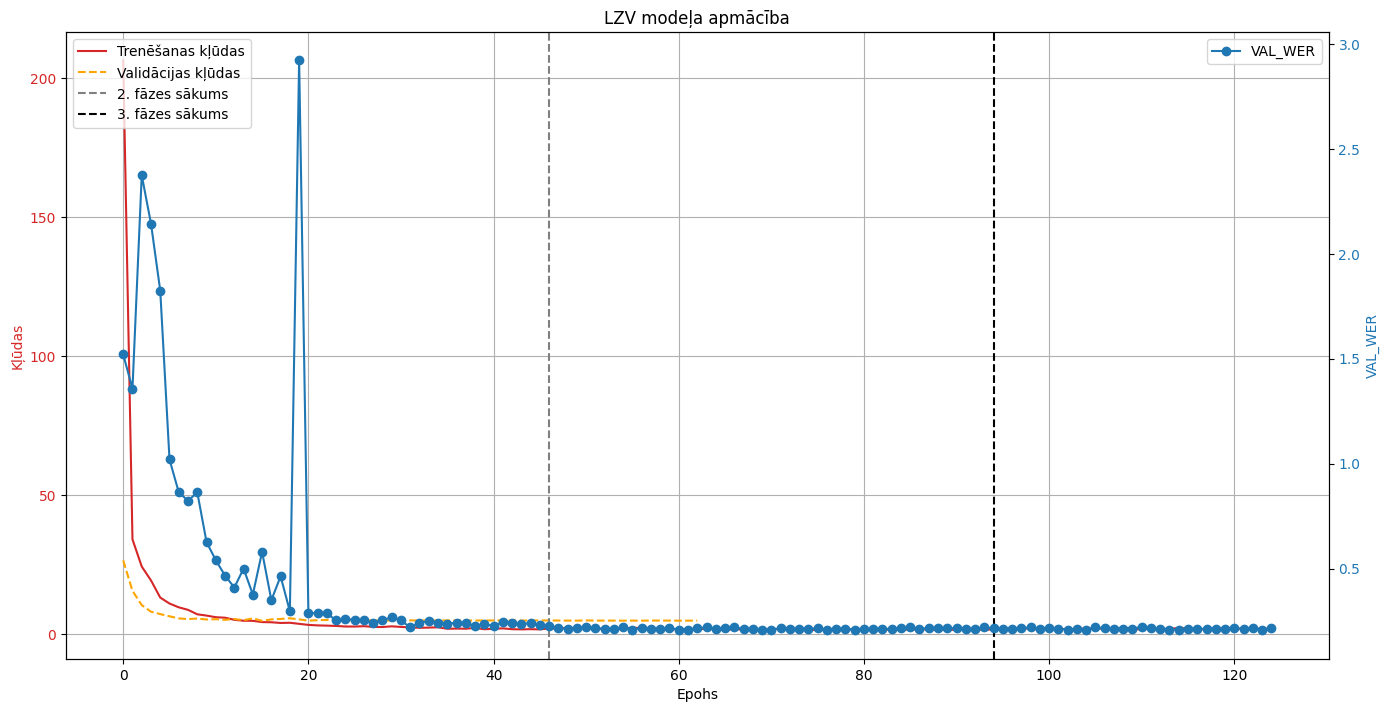


Saving LZV experiment data to: c:\Users\liene\Documents\GitHub\LZV-CSLR\models\lzv\1\lzv_exp_data_1.json

Generating LZV prediction examples for JSON (Phase 1)...
Generated 64 LZV prediction examples for Phase 1.
  Content of target_list_in_run_data for Phase 1 after generation: [{'ground_truth': '9   ļ o t i   s ē ņ o', 'prediction': '9   ļ o t i   s ē ņ o'}, {'ground_truth': 'č u k   č u k', 'prediction': 'č u k   č u'}, {'ground_truth': '10   t a g a d', 'prediction': '10   t a g a d'}, {'ground_truth': 'v a i   t ā p ā t', 'prediction': 'v a i   t ā p ā a t  '}, {'ground_truth': '1', 'prediction': '<empty_pred>'}, {'ground_truth': 'c', 'prediction': 'c'}, {'ground_truth': 'l a b i   g a n   t ā', 'prediction': 'l a b i g a n t'}, {'ground_truth': 'm', 'prediction': 'm'}, {'ground_truth': '9', 'prediction': '9'}, {'ground_truth': 'd i v i', 'prediction': 'd i v i'}, {'ground_truth': 's p ē l ē   ģ i t ā r u', 'prediction': 's p ē l ē   ģ i t ā r u'}, {'ground_truth': '9 8 7', 'pred

In [11]:
# Cik daudz reizes trenēt modeli, 1=1 reizi
for _ in range(1):
        
    print("\n--- Preparing for training ---")

    try:
        if BATCH_SIZE <= 0:
            raise ValueError("BATCH_SIZE must be positive.")

        steps_per_epoch = math.ceil(NUM_TRAIN_SAMPLES_AFTER_FILTER / BATCH_SIZE)
        validation_steps_for_keras = math.ceil(NUM_VAL_SAMPLES_AFTER_FILTER / BATCH_SIZE)
        validation_steps_for_callback = validation_steps_for_keras

        print(f"LZV Training Samples (post-filter): {NUM_TRAIN_SAMPLES_AFTER_FILTER}")
        print(f"LZV Validation Samples (post-filter): {NUM_VAL_SAMPLES_AFTER_FILTER}")
        print(f"Batch Size: {BATCH_SIZE}")
        print(f"Learning Rate for fine-tuning: {LEARNING_RATE}")
        print(f"Calculated steps_per_epoch: {steps_per_epoch}")
        print(f"Calculated validation_steps (for Keras & WER Callback): {validation_steps_for_keras}")

    except Exception as e:
        print(f"Error: {e}")
        sys.exit(1)

    # Pārbaude
    try:
        current_experiment_index = find_next_experiment_index(OUTPUT_DIR)
        experiment_dir = os.path.join(OUTPUT_DIR, str(current_experiment_index))
        os.makedirs(experiment_dir, exist_ok=True)
        print(f"\nLZV experiment results will be saved in: {experiment_dir}")

        checkpoint_filename = f"lzv_finetuned_model_best_exp{current_experiment_index}.keras"
        checkpoint_filepath = os.path.join(experiment_dir, checkpoint_filename)
        
        prediction_model_filename = f"lzv_prediction_model_final_exp{current_experiment_index}.keras"
        prediction_model_save_path = os.path.join(experiment_dir, prediction_model_filename)
        
        json_filename = f"lzv_exp_data_{current_experiment_index}.json"
        json_save_path = os.path.join(experiment_dir, json_filename)
        
        plot_filename = f"lzv_plot_exp{current_experiment_index}.png"
        plot_path = os.path.join(experiment_dir, plot_filename)

    except Exception as e:
        print(f"Error setting up LZV experiment directory or paths: {e}. Exiting.")
        sys.exit(1)

    combined_history_data = {'loss': [], 'val_loss': [], 'val_wer': [], 'lr': []}

    training_start_time = time.monotonic()
    print(f"\nStarted at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')})...")


    # --- 1. Fāze ---
    print("\n--- PHASE 1 ---")
    asl_training_model_base_loaded.trainable = False
    print(f"Base model '{asl_training_model_base_loaded.name}' trainable: {asl_training_model_base_loaded.trainable}")
    training_model.get_layer('output_dense_softmax_lzv').trainable = True

    print("Trainable params for Phase 1:")
    training_model.summary(line_length=100)

    optimizer_phase1 = keras.optimizers.Adam(learning_rate=LR_PHASE_1, clipnorm=1.0)
    training_model.compile(optimizer=optimizer_phase1, loss=lambda y_true, y_pred: y_pred, metrics=[])
    print(f"Model compiled for Phase 1 with LR: {LR_PHASE_1}")

    phase1_log_prefix = 'val_wer_phase1'
    checkpoint_filepath_phase1 = os.path.join(experiment_dir, f"lzv_model_phase1_best_exp{current_experiment_index}.keras")
    model_checkpoint_phase1 = ModelCheckpoint(filepath=checkpoint_filepath_phase1, monitor=phase1_log_prefix, save_best_only=True, mode='min', verbose=1)
    early_stopping_phase1 = EarlyStopping(monitor=phase1_log_prefix, patience=15, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_phase1 = keras.callbacks.ReduceLROnPlateau(monitor=phase1_log_prefix, factor=0.3, patience=7, min_lr=1e-5, verbose=1)
    wer_callback_phase1 = WERCallback(prediction_model, validation_dataset_batched, validation_steps_for_callback, inverse_char_map, log_prefix=phase1_log_prefix)

    print(f"Starting Phase 1 training for {EPOCHS_PHASE_1} epochs...")
    history_phase1 = training_model.fit(
        train_dataset_prepared,
        epochs=EPOCHS_PHASE_1,
        steps_per_epoch=steps_per_epoch,
        callbacks=[wer_callback_phase1, early_stopping_phase1, model_checkpoint_phase1, reduce_lr_phase1],
        validation_data=validation_dataset_prepared,
        validation_steps=validation_steps_for_keras,
        verbose=1
    )
    if os.path.exists(checkpoint_filepath_phase1) and early_stopping_phase1.stopped_epoch > 0:
        print(f"Loading best weights from Phase 1 checkpoint: {checkpoint_filepath_phase1}")
        training_model.load_weights(checkpoint_filepath_phase1)

    current_input_tensor = training_model.get_layer('input_landmarks').input
    current_logits_output_tensor = training_model.get_layer('output_dense_softmax_lzv').output

    # Saglabā datus 1. fāzei
    epochs_completed_phase1 = len(history_phase1.history['loss'])
    combined_history_data['loss'].extend(history_phase1.history['loss'])
    combined_history_data['val_loss'].extend(history_phase1.history.get('val_loss', [None]*epochs_completed_phase1))
    combined_history_data['val_wer'].extend(history_phase1.history[phase1_log_prefix])
    combined_history_data['lr'].extend(history_phase1.history['learning_rate'])


    # --- 2. Fāze ---
    print("\n--- PHASE 2: Fine-tuning Top Layers of the Base Model ---")
    asl_training_model_base_loaded.trainable = True
    unfrozen_in_phase2 = []
    for layer in asl_training_model_base_loaded.layers:
        if layer.name in ['bilstm_1', 'batchnorm_lstm1']:
            if not layer.trainable: layer.trainable = True; unfrozen_in_phase2.append(layer.name)
        elif layer.name != 'input_landmarks':
            if layer.trainable: layer.trainable = False
    print(f"  Unfrozen in Phase 2: {unfrozen_in_phase2 if unfrozen_in_phase2 else 'None (already trainable or not found)'}")
    print(f"  Base model '{asl_training_model_base_loaded.name}' trainable: {asl_training_model_base_loaded.trainable}")
    training_model.get_layer('output_dense_softmax_lzv').trainable = True 
    print("Trainable params for Phase 2:")
    training_model.summary(line_length=100)

    optimizer_phase2 = keras.optimizers.Adam(learning_rate=LR_PHASE_2, clipnorm=1.0)
    training_model.compile(optimizer=optimizer_phase2, loss=lambda y_true, y_pred: y_pred, metrics=[])
    print(f"Model re-compiled for Phase 2 with LR: {LR_PHASE_2}")

    phase2_log_prefix = 'val_wer_phase2'
    checkpoint_filepath_phase2 = os.path.join(experiment_dir, f"lzv_model_phase2_best_exp{current_experiment_index}.keras")
    model_checkpoint_phase2 = ModelCheckpoint(filepath=checkpoint_filepath_phase2, monitor=phase2_log_prefix, save_best_only=True, mode='min', verbose=1)
    early_stopping_phase2 = EarlyStopping(monitor=phase2_log_prefix, patience=25, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_phase2 = keras.callbacks.ReduceLROnPlateau(monitor=phase2_log_prefix, factor=0.3, patience=10, min_lr=1e-6, verbose=1)
    wer_callback_phase2 = WERCallback(prediction_model, validation_dataset_batched, validation_steps_for_callback, inverse_char_map, log_prefix=phase2_log_prefix)

    print(f"Starting Phase 2 training for {EPOCHS_PHASE_2} epochs, continuing from epoch {epochs_completed_phase1}...")
    history_phase2 = training_model.fit(
        train_dataset_prepared,
        epochs=epochs_completed_phase1 + EPOCHS_PHASE_2,
        initial_epoch=epochs_completed_phase1,
        steps_per_epoch=steps_per_epoch,
        callbacks=[wer_callback_phase2, early_stopping_phase2, model_checkpoint_phase2, reduce_lr_phase2],
        validation_data=validation_dataset_prepared,
        validation_steps=validation_steps_for_keras,
        verbose=1
    )
    if os.path.exists(checkpoint_filepath_phase2) and early_stopping_phase2.stopped_epoch > 0:
        print(f"Loading best weights from Phase 2 checkpoint: {checkpoint_filepath_phase2}")
        training_model.load_weights(checkpoint_filepath_phase2)

    # Saglabā datus 2. fāzei
    epochs_in_phase2 = len(history_phase2.history['loss'])
    combined_history_data['loss'].extend(history_phase2.history['loss'])
    combined_history_data['val_loss'].extend(history_phase2.history.get('val_loss', [None]*epochs_in_phase2))
    combined_history_data['val_wer'].extend(history_phase2.history[phase2_log_prefix])
    combined_history_data['lr'].extend(history_phase2.history['learning_rate'])
    epochs_completed_phase2 = epochs_completed_phase1 + epochs_in_phase2
    if hasattr(early_stopping_phase2, 'stopped_epoch') and early_stopping_phase2.stopped_epoch > 0:
        epochs_completed_phase2 = early_stopping_phase2.stopped_epoch


    # --- 3. Fāze ---
    print("\n--- PHASE 3: Fine-tuning More Base Layers (including Conv1D) ---")
    print("Setting trainable status for Phase 3:")
    unfrozen_in_phase3 = []
    for layer in asl_training_model_base_loaded.layers:
        if layer.name in ['conv1d_layer', 'batchnorm_conv', 'bilstm_1', 'batchnorm_lstm1']:
            if not layer.trainable: layer.trainable = True; unfrozen_in_phase3.append(layer.name)
        elif layer.name != 'input_landmarks':
            if layer.trainable: layer.trainable = False
    print(f"  Unfrozen in Phase 3 (or confirmed): {unfrozen_in_phase3 if unfrozen_in_phase3 else 'None (already trainable or not found)'}")
    training_model.get_layer('output_dense_softmax_lzv').trainable = True
    print("Trainable params for Phase 3:")
    training_model.summary(line_length=100)

    optimizer_phase3 = keras.optimizers.Adam(learning_rate=LR_PHASE_3, clipnorm=1.0) # Start with LR_PHASE_3
    training_model.compile(optimizer=optimizer_phase3, loss=lambda y_true, y_pred: y_pred, metrics=[])
    print(f"Model re-compiled for Phase 3 with LR: {LR_PHASE_3}")

    phase3_log_prefix = 'val_wer_phase3'
    checkpoint_filepath_phase3 = os.path.join(experiment_dir, f"lzv_model_phase3_best_exp{current_experiment_index}.keras")
    model_checkpoint_phase3 = ModelCheckpoint(filepath=checkpoint_filepath_phase3, monitor=phase3_log_prefix, save_best_only=True, mode='min', verbose=1)
    early_stopping_phase3 = EarlyStopping(monitor=phase3_log_prefix, patience=20, verbose=1, mode='min', restore_best_weights=True) # Longer patience
    reduce_lr_phase3 = keras.callbacks.ReduceLROnPlateau(monitor=phase3_log_prefix, factor=0.3, patience=10, min_lr=5e-8, verbose=1)
    wer_callback_phase3 = WERCallback(prediction_model, validation_dataset_batched, validation_steps_for_callback, inverse_char_map, log_prefix=phase3_log_prefix)

    print(f"Starting Phase 3 training for {EPOCHS_PHASE_3} epochs, continuing from epoch {epochs_completed_phase2}...")
    history_phase3 = training_model.fit(
        train_dataset_prepared,
        epochs=epochs_completed_phase2 + EPOCHS_PHASE_3,
        initial_epoch=epochs_completed_phase2,
        steps_per_epoch=steps_per_epoch,
        callbacks=[wer_callback_phase3, early_stopping_phase3, model_checkpoint_phase3, reduce_lr_phase3],
        validation_data=validation_dataset_prepared,
        validation_steps=validation_steps_for_keras,
        verbose=1
    )

    if os.path.exists(checkpoint_filepath_phase3) and early_stopping_phase3.stopped_epoch > 0:
        print(f"Loading best weights from Phase 3 checkpoint: {checkpoint_filepath_phase3}")
        training_model.load_weights(checkpoint_filepath_phase3)

    # Saglabā datus 3. fāzei
    epochs_in_phase3 = len(history_phase3.history['loss'])
    combined_history_data['loss'].extend(history_phase3.history['loss'])
    combined_history_data['val_loss'].extend(history_phase3.history.get('val_loss', [None]*epochs_in_phase3))
    combined_history_data['val_wer'].extend(history_phase3.history[phase3_log_prefix])
    combined_history_data['lr'].extend(history_phase3.history['learning_rate'])
    epochs_actually_run_total = epochs_completed_phase2 + epochs_in_phase3


    # --- Saglabāšana ---
    print("\n--- Post-Phased Fine-tuning: Saving LZV Results ---")
    elapsed_training_seconds = time.monotonic() - training_start_time
    training_successful = True

    if training_successful:
        if prediction_model is not None:
            prediction_model.save(prediction_model_save_path)
            print(f"Final LZV prediction model saved to: {prediction_model_save_path}")
        
        overall_best_wer = min(combined_history_data['val_wer'])
        overall_best_epoch = combined_history_data['val_wer'].index(overall_best_wer) + 1

        print(f"Overall best val_wer: {overall_best_wer:.4f} at cumulative epoch {overall_best_epoch}")

        # Grafs trenēšanas kļūdām un WER
        if combined_history_data['loss']:
            print(f"\nGenerating and saving LZV plot to: {plot_path}")
            fig, ax1 = plt.subplots(figsize=(14, 7))
            color = 'tab:red'
            ax1.set_xlabel('Epohs')
            ax1.set_ylabel('Kļūdas', color=color)
            ax1.plot(combined_history_data['loss'], color=color, label='Trenēšanas kļūdas')
            if combined_history_data['val_loss'] and any(vl is not None for vl in combined_history_data['val_loss']):
                ax1.plot(combined_history_data['val_loss'], color='orange', linestyle='--', label='Validācijas kļūdas')
            ax1.tick_params(axis='y', labelcolor=color)
            
            epochs_p1_end = len(history_phase1.history['loss']) if history_phase1 else 0
            epochs_p2_end = epochs_p1_end + (len(history_phase2.history['loss']) if history_phase2 else 0)

            if epochs_p1_end > 0:
                ax1.axvline(x=epochs_p1_end -1 , color='gray', linestyle='--', label=f'2. fāzes sākums')
            if epochs_p2_end > epochs_p1_end:
                ax1.axvline(x=epochs_p2_end -1, color='black', linestyle='--', label=f'3. fāzes sākums')
            
            ax1.legend(loc='upper left')
            ax1.grid(True)

            ax2 = ax1.twinx()
            color = 'tab:blue'
            ax2.set_ylabel('VAL_WER', color=color)
            ax2.plot(combined_history_data['val_wer'], color=color, marker='o', linestyle='-', label='VAL_WER')
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.legend(loc='upper right')
            
            fig.tight_layout()
            plt.title(f'LZV modeļa apmācība')
            plt.savefig(plot_path)
            print(f"LZV Plot saved successfully to {plot_path}.")
            plt.show()
        else:
            print("No history data to plot.")

        # --- Saglabā metadatus JSON ---
        print(f"\nSaving LZV experiment data to: {json_save_path}")
        run_data = {}
        try:
            run_data["experiment_type"] = "Fine-tuning LZV"
            run_data["base_asl_model_path"] = ASL_MODEL_PATH
            run_data["experiment_index"] = current_experiment_index
            run_data["timestamp_completed_utc"] = datetime.now(timezone.utc).isoformat(timespec='seconds')
            
            run_data["dataset_info"] = {
                "name": dataset_info.get("dataset_name", "LZV"),
                "training_samples_final_filtered": NUM_TRAIN_SAMPLES_AFTER_FILTER,
                "validation_samples_final_filtered": NUM_VAL_SAMPLES_AFTER_FILTER,
                "total_classes_lzv_excl_blank": NUM_CLASSES,
                "total_classes_lzv_incl_blank": NUM_CLASSES_WITH_BLANK,
                "char_map_file": os.path.relpath(CHAR_MAP_FILE, BASE_DIR) if 'BASE_DIR' in locals() and CHAR_MAP_FILE else CHAR_MAP_FILE,
                "train_tfrecord": os.path.basename(TFRECORD_FILE),
                "val_tfrecord": os.path.basename(TFRECORD_FILE_VAL)
            }
            run_data["landmark_info"] = {
                "source": "MediaPipe Holistic",
                "original_total_landmarks": ORIGINAL_NUM_LANDMARKS,
                "used_landmarks_count": NUM_LANDMARKS,
                "dimensions": LANDMARK_DIMS,
            }
            run_data["preprocessing"] = {
                "normalization_source": "calculated_on_the_spot",
                "ctc_length_filter_applied": True
            }
            run_data["augmentation_details"] = {
                "enabled": USE_AUGMENTATION,
                "spatial_affine": True if USE_AUGMENTATION else False,
                "horizontal_flip": True if USE_AUGMENTATION and USE_FLIP_AUGMENTATION else False,
                "temporal_resample": True if USE_AUGMENTATION else False,
                "temporal_mask": True if USE_AUGMENTATION else False,
            }

            model_config = {}
            try:
                if training_model: model_config = training_model.get_config()
            except Exception as cfg_e: print(f"Warning: Could not get full model config: {cfg_e}")

            run_data["model_architecture_fine_tuned"] = {
                "config": model_config,
                "params_total": training_model.count_params() if training_model else None,
                "params_trainable": sum([w.shape.num_elements() for w in training_model.trainable_weights]) if training_model else None,
            }

            if combined_history_data['val_wer']:
                best_val_wer_overall = min(val for val in combined_history_data['val_wer'] if val is not None)
                best_val_wer_epoch_overall = combined_history_data['val_wer'].index(best_val_wer_overall) + 1
            else:
                best_val_wer_overall = None
                best_val_wer_epoch_overall = None

            final_train_loss = combined_history_data['loss'][-1] if combined_history_data['loss'] else None
            final_val_wer = combined_history_data['val_wer'][-1] if combined_history_data['val_wer'] else None
            
            run_data["results"] = {
                "best_val_wer_overall": best_val_wer_overall,
                "best_val_wer_epoch_overall": best_val_wer_epoch_overall,
                "final_train_loss": final_train_loss,
                "final_val_wer": final_val_wer,
                "epoch_metrics": [
                    {
                        "epoch": i + 1,
                        "loss": combined_history_data['loss'][i] if i < len(combined_history_data['loss']) else None,
                        "val_loss": combined_history_data['val_loss'][i] if i < len(combined_history_data['val_loss']) else None,
                        "val_wer": combined_history_data['val_wer'][i] if i < len(combined_history_data['val_wer']) else None,
                        "lr": combined_history_data['lr'][i] if i < len(combined_history_data['lr']) else None,
                    }
                    for i in range(epochs_actually_run_total)
                ],
            }


            # Saglabā minējumus (neobligāti 1. un 2. fāzei)
            run_data["prediction_examples_lzv_phase1"] = []
            generate_and_log_predictions("Phase 1", prediction_model, validation_dataset_batched, wer_callback_phase1, 64, BATCH_SIZE, run_data["prediction_examples_lzv_phase1"])

            run_data["prediction_examples_lzv_phase2"] = []
            generate_and_log_predictions("Phase 2", prediction_model, validation_dataset_batched, wer_callback_phase2, 64, BATCH_SIZE, run_data["prediction_examples_lzv_phase2"])

            run_data["prediction_examples_lzv_phase3"] = []
            generate_and_log_predictions("Phase 3", prediction_model, validation_dataset_batched, wer_callback_phase3, 64, BATCH_SIZE, run_data["prediction_examples_lzv_phase3"])
            

            best_checkpoint_path_overall = ""
            if best_val_wer_epoch_overall <= epochs_completed_phase1:
                best_checkpoint_path_overall = checkpoint_filepath_phase1
            elif best_val_wer_epoch_overall <= epochs_completed_phase2:
                best_checkpoint_path_overall = checkpoint_filepath_phase2
            else:
                best_checkpoint_path_overall = checkpoint_filepath_phase3


            run_data["saved_files"] = {
                "best_fine_tuned_training_checkpoint": checkpoint_filename,
                "final_lzv_prediction_model": prediction_model_filename,
                "plot": plot_filename, "experiment_data_json": json_filename
            }

            print("\n--- Content of run_data before saving to JSON ---")
            print(json.dumps(run_data, indent=4, default=str, ensure_ascii=False))
            
            with open(json_save_path, "w", encoding='utf-8') as f:
                json.dump(run_data, f, indent=4, default=str, ensure_ascii=False)
            print("LZV Experiment data JSON saved successfully.")

        except Exception as json_e:
            print(f"Error populating or saving LZV experiment data JSON: {json_e}")

    else:
        print("Skipping LZV model phased fine-tuning due to missing components.")